In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import pickle

In [2]:
# Load metrics from a pickle file

with open("metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

In [76]:
models   = list(metrics.keys())
versions = ["no_cot", "cot"]
colors   = {"med42":"C0", "meditron":"C1", "openbio":"C2", "ours":"C3", "ours_med42":"C4"}
styles   = {"no_cot":"-",    "cot":"--"}
name_map = {"med42":"Med42", "meditron":"Meditron", "openbio":"OpenBio", "ours":"Ours (LLaMa3)", "ours_med42":"Ours (Med42)", "no_cot":"No COT", "cot":"COT"}

In [63]:
plt.rcParams.update({'font.size': 18})

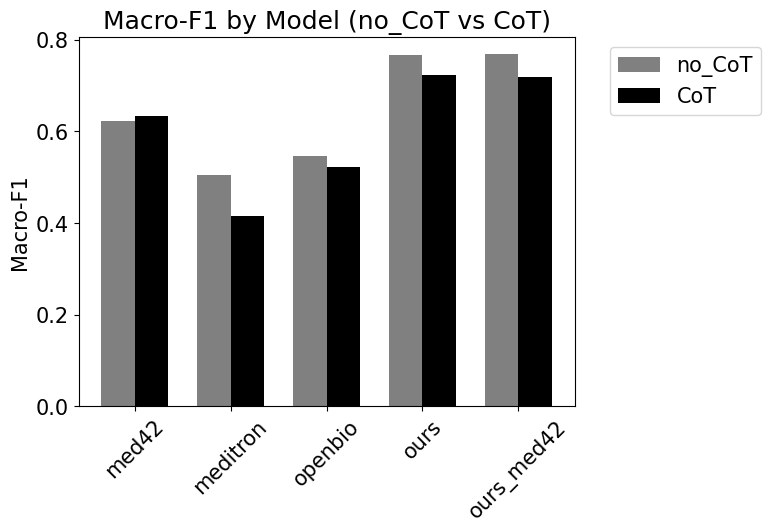

In [10]:
# 1) Bar chart of Macro‑F1
x    = np.arange(len(models))
w    = 0.35
f1_no = [metrics[m]["no_cot"]["macro_f1"] for m in models]
f1_co = [metrics[m]["cot"]["macro_f1"]   for m in models]
fig, ax = plt.subplots()
ax.bar(x - w/2, f1_no, w, label="no_CoT", color="gray")
ax.bar(x + w/2, f1_co, w, label="CoT",   color="black")
ax.set_xticks(x); ax.set_xticklabels(models)
ax.set_ylabel("Macro‑F1")
ax.set_title("Macro‑F1 by Model (no_CoT vs CoT)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()


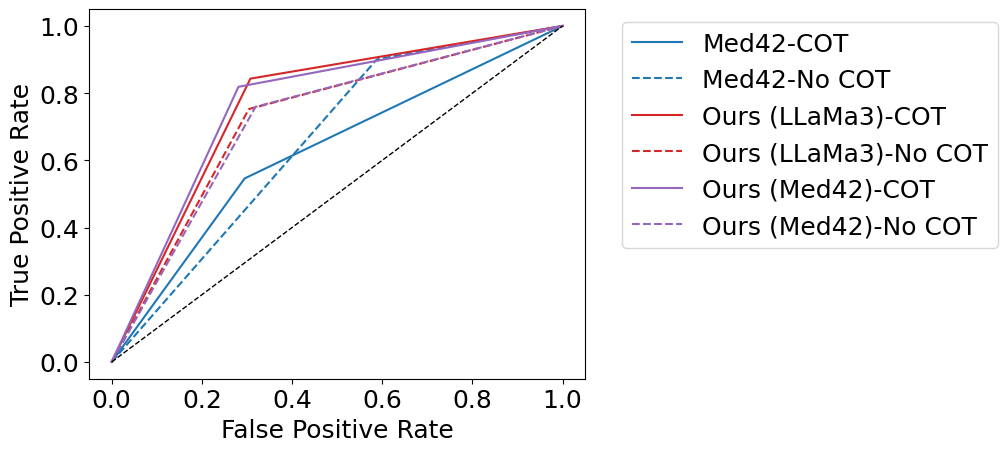

In [73]:
# Remove 'meditron' and 'openbio' from models
models = [m for m in models if m not in ['meditron', 'openbio']]

# 2) Combined ROC curves
fig, ax = plt.subplots()
for m in models:
    for v in versions:
        y_true  = metrics[m][v]["y_true_cls"]
        y_score = metrics[m][v].get("y_score", metrics[m][v]["y_pred_cls"])
        fpr, tpr, _ = roc_curve(y_true, y_score)
        a          = auc(fpr, tpr)
        ax.plot(fpr, tpr, linestyle=styles[v], color=colors[m],
                label=f"{name_map[m]}-{name_map[v]}")
ax.plot([0,1], [0,1], "k--", linewidth=1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
# ax.set_title("ROC Curves")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.tight_layout()
plt.savefig("plots/roc_curves.pdf", bbox_inches="tight")
plt.show()


/scratch/rh3884/tmp/ipykernel_3794826/3843340728.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


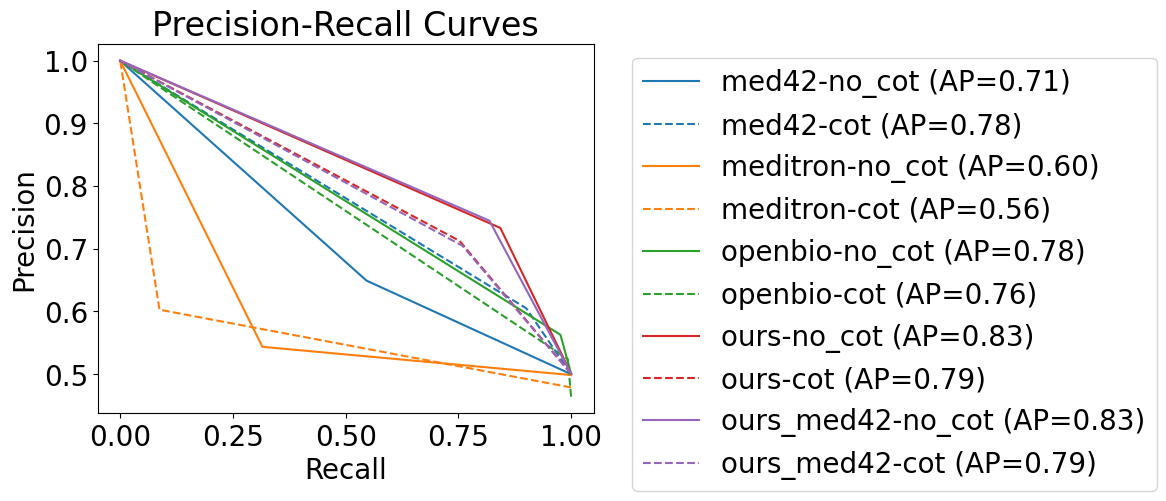

In [8]:

# 3) Combined Precision‑Recall curves
fig, ax = plt.subplots()
for m in models:
    for v in versions:
        y_true  = metrics[m][v]["y_true_cls"]
        y_score = metrics[m][v].get("y_score", metrics[m][v]["y_pred_cls"])
        p, r, _ = precision_recall_curve(y_true, y_score)
        ap      = auc(r, p)
        ax.plot(r, p, linestyle=styles[v], color=colors[m],
                label=f"{m}-{v} (AP={ap:.2f})")
ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
ax.set_title("Precision‑Recall Curves")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

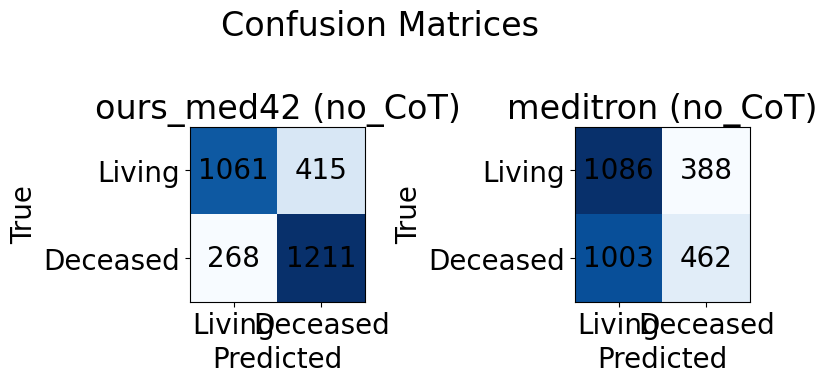

In [9]:
# 4) Confusion matrices for best/worst by no_CoT Macro‑F1
best  = max(models, key=lambda m: metrics[m]["no_cot"]["macro_f1"])
worst= min(models, key=lambda m: metrics[m]["no_cot"]["macro_f1"])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
for ax, m in zip([ax1, ax2], [best, worst]):
    cm = confusion_matrix(metrics[m]["no_cot"]["y_true_cls"],
                          metrics[m]["no_cot"]["y_pred_cls"])
    im = ax.imshow(cm, cmap="Blues")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i,j], ha="center", va="center")
    ax.set_title(f"{m} (no_CoT)")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Living","Deceased"])
    ax.set_yticklabels(["Living","Deceased"])
fig.suptitle("Confusion Matrices")
plt.tight_layout()
plt.show()

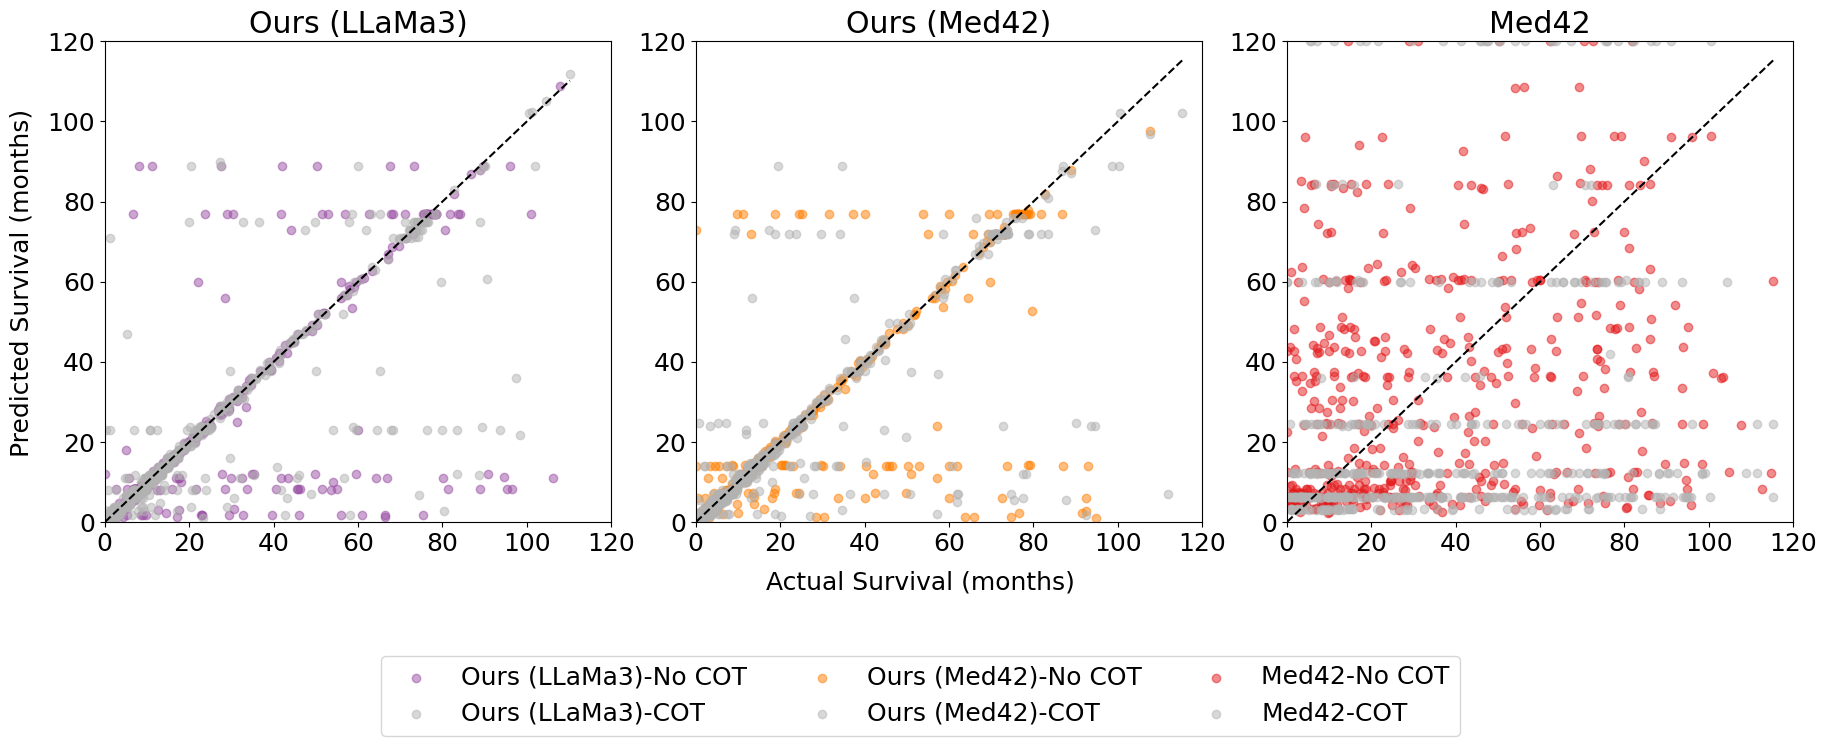

In [84]:
# Update colors with a new color combination
colors = {"med42": "#e41a1c", "meditron": "#377eb8", "openbio": "#4daf4a", "ours": "#984ea3", "ours_med42": "#ff7f00"}

# 5) Scatter Predicted vs Actual Survival (separate plots for each model with random sampling and different axis ranges)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for ax, model in zip(axes, ["ours", "ours_med42", "med42"]):
    for v in versions:
        x = metrics[model][v]["y_true_reg"]
        y = metrics[model][v]["y_pred_reg"]
        
        if model in ["ours", "ours_med42"]:
            # Calculate absolute differences and sort indices by proximity to equality line
            abs_diff = np.abs(np.array(x) - np.array(y))
            sorted_indices = np.argsort(abs_diff)
            # Sample more points closer to the equality line
            indices = np.concatenate([
                sorted_indices[:400],  # Closest 400 points
                np.random.choice(sorted_indices[400:], size=100, replace=False)  # Random 100 points
            ])
        else:
            # Randomly sample 500 points for other models
            indices = np.random.choice(len(x), size=500, replace=False)
        
        sampled_x = np.array(x)[indices]
        sampled_y = np.array(y)[indices]
        
        ax.scatter(sampled_x, sampled_y, alpha=0.5, label=f"{name_map[model]}-{name_map[v]}",
                   color=colors[model] if v == "no_cot" else plt.cm.gray(0.7))  # Use a lighter gray (70% intensity) for CoT
    
    ax.plot([min(sampled_x), max(sampled_x)], [min(sampled_x), max(sampled_x)], "k--")
    ax.set_title(f"{name_map[model]}")
    
    # Set different axis ranges for each model
    if model == "ours":
        ax.set_xlim(0, 120)
        ax.set_ylim(0, 120)
    elif model == "ours_med42":
        ax.set_xlim(0, 120)
        ax.set_ylim(0, 120)
    elif model == "med42":
        ax.set_xlim(0, 120)
        ax.set_ylim(0, 120)

# Add a single x and y label for all plots with adjusted positions to avoid overlapping with ticks
fig.text(0.5, 0.001, "Actual Survival (months)", ha="center", va="center")
fig.text(0.001, 0.5, "Predicted Survival (months)", ha="center", va="center", rotation="vertical")

# Add a single legend below the plots
fig.legend(bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=3)
plt.tight_layout()
plt.savefig("plots/scatter_predicted_vs_actual_survival.pdf", bbox_inches="tight")
plt.show()

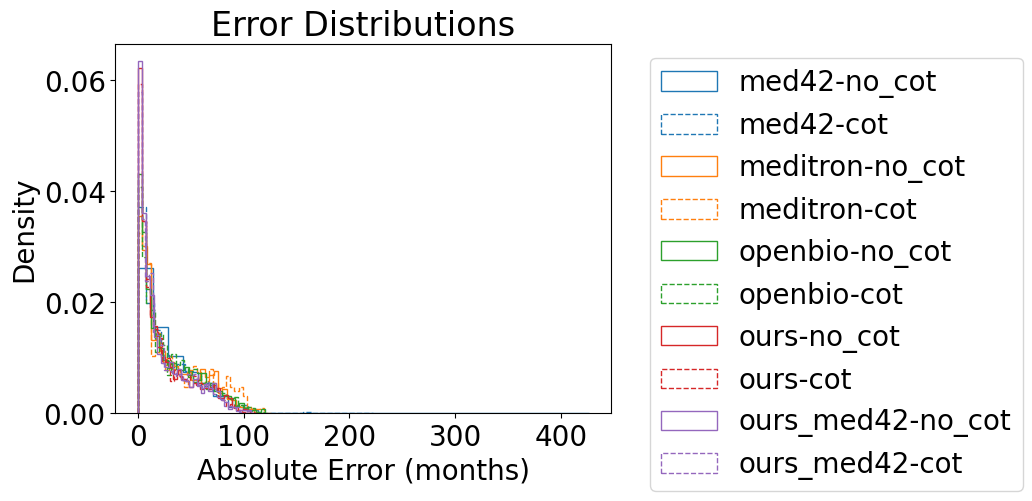

In [12]:
# 6) Histogram of absolute errors
fig, ax = plt.subplots()
for m in models:
    for v in versions:
        errs = metrics[m][v]["abs_errors"]
        ax.hist(errs, bins=30, histtype="step",
                linestyle=styles[v], color=colors[m],
                label=f"{m}-{v}", density=True)
ax.set_xlabel("Absolute Error (months)")
ax.set_ylabel("Density")
ax.set_title("Error Distributions")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
# plt.tight_layout()
plt.show()


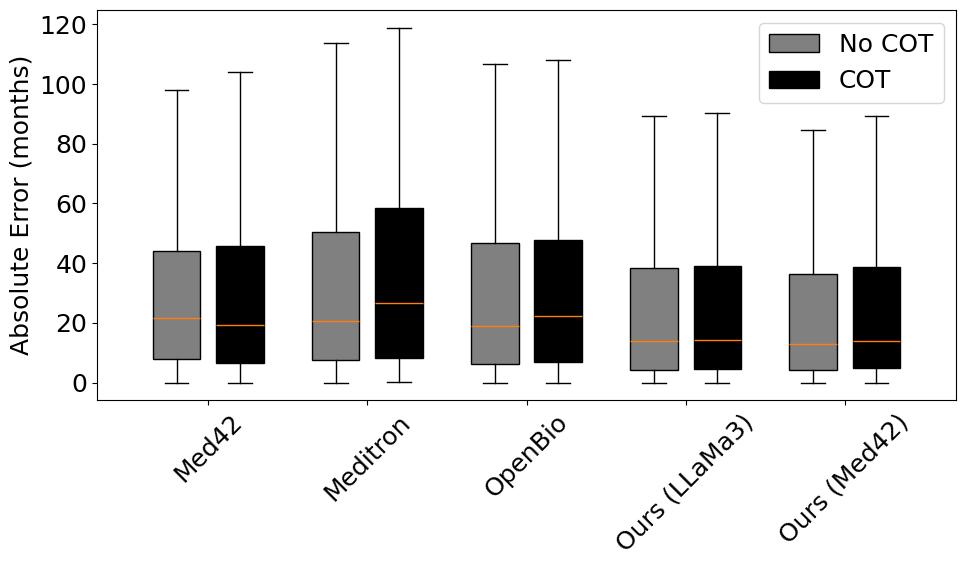

In [88]:
# 7) Boxplot of absolute errors with grouped dimensions
fig, ax = plt.subplots(figsize=(10, 6))
data_no_cot = [metrics[m]["no_cot"]["abs_errors"] for m in models]
data_cot = [metrics[m]["cot"]["abs_errors"] for m in models]

# Combine data for boxplots
data = data_no_cot + data_cot
positions = np.arange(len(models))  # Base positions for models
positions_no_cot = positions - 0.2
positions_cot = positions + 0.2

# Plot boxplots for no_cot and cot
bp_no_cot = ax.boxplot(data_no_cot, positions=positions_no_cot, widths=0.3, patch_artist=True, boxprops=dict(facecolor="gray"), showfliers=False)
bp_cot = ax.boxplot(data_cot, positions=positions_cot, widths=0.3, patch_artist=True, boxprops=dict(facecolor="black"), showfliers=False)

# Update x-ticks and labels
ax.set_xticks(positions)
ax.set_xticklabels([name_map[m] for m in models])
ax.set_ylabel("Absolute Error (months)")
# ax.set_title("Error Distribution by Model")
ax.legend([bp_no_cot["boxes"][0], bp_cot["boxes"][0]], ["No COT", "COT"], loc="upper right")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/boxplot_absolute_errors.pdf", bbox_inches="tight")
plt.show()

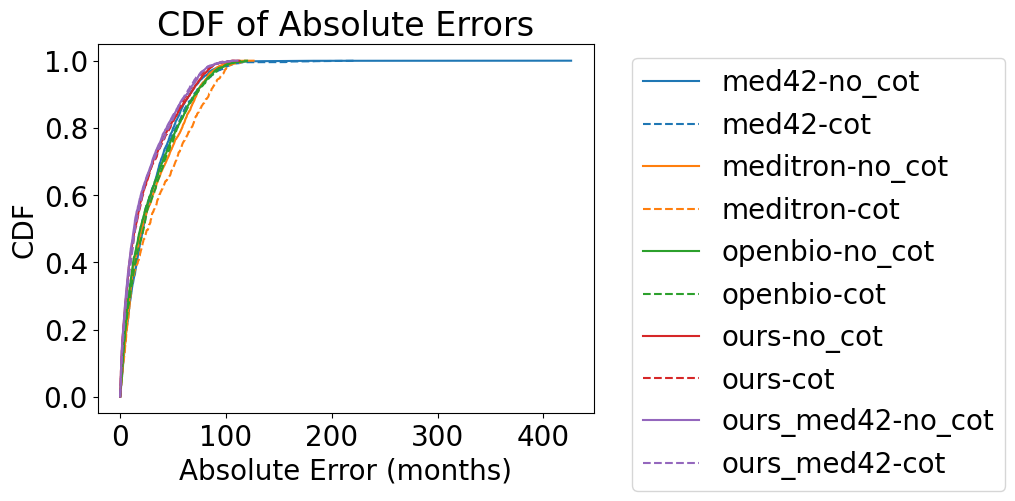

In [15]:
# 8) CDF of absolute errors
fig, ax = plt.subplots()
for m in models:
    for v in versions:
        errs = np.sort(metrics[m][v]["abs_errors"])
        cdf  = np.arange(1, len(errs)+1) / len(errs)
        ax.plot(errs, cdf, linestyle=styles[v], color=colors[m],
                label=f"{m}-{v}")
ax.set_xlabel("Absolute Error (months)")
ax.set_ylabel("CDF")
ax.set_title("CDF of Absolute Errors")
ax.legend(bbox_to_anchor=(1.05,1), loc="upper left")
# plt.tight_layout()
plt.show()

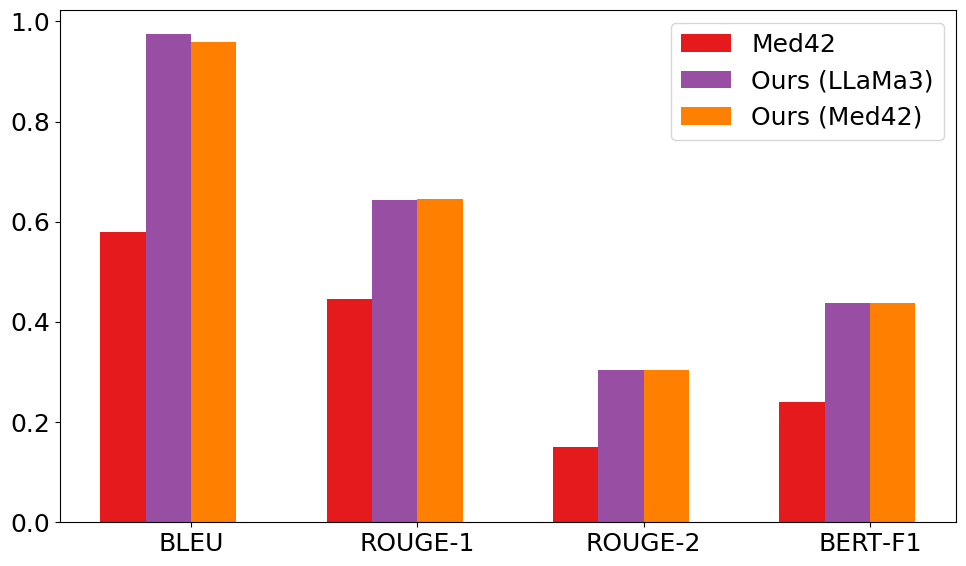

In [93]:
# Normalize the metrics to bring them into a comparable range
models = [m for m in models if m not in ['meditron', 'openbio']]
gen_metrics = ["bleu", "rouge1", "rouge2", "bert_f1"]
x = np.arange(len(gen_metrics))
w = 0.2
fig, ax = plt.subplots(figsize=(10, 6))

# Define normalization factors for each metric
normalization_factors = {
    "bleu": 100,  # BLEU is typically a percentage
    "rouge1": 1,  # ROUGE-1 is already in [0, 1]
    "rouge2": 1,  # ROUGE-2 is already in [0, 1]
    "bert_f1": 1  # BERT-F1 is already in [0, 1]
}

for i, m in enumerate(models):
    vals = [
        (metrics[m]["cot"][gm].score if gm == "bleu" else metrics[m]["cot"][gm]) / normalization_factors[gm]
        for gm in gen_metrics
    ]
    ax.bar(x + (i - 1.5) * w, vals, width=w, color=colors[m], label=name_map[m])

ax.set_xticks(x)
ax.set_xticklabels(["BLEU", "ROUGE‑1", "ROUGE‑2", "BERT‑F1"])
# ax.set_title("Generation Quality (CoT)")
ax.legend()
plt.tight_layout()
plt.savefig("plots/generation_quality_cot.pdf", bbox_inches="tight")
plt.show()

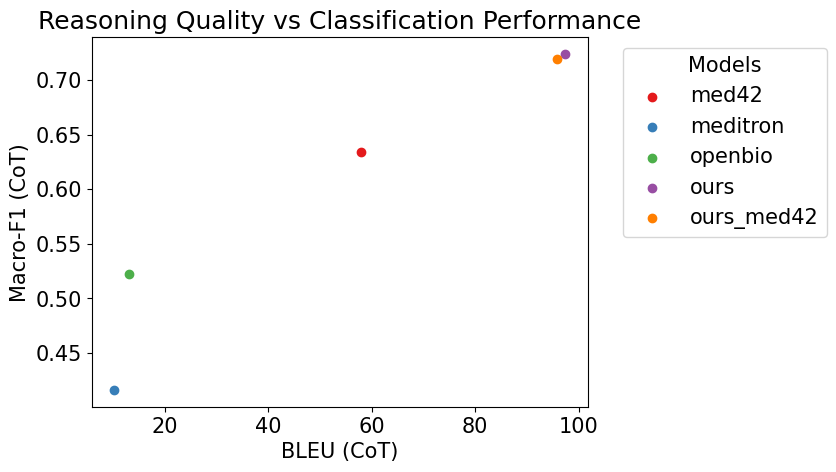

In [32]:
# 10) Scatter Generation Quality vs Classification F1
models = list(metrics.keys())
fig, ax = plt.subplots()
for m in models:
    bleu = metrics[m]["cot"]["bleu"].score if hasattr(metrics[m]["cot"]["bleu"], 'score') else metrics[m]["cot"]["bleu"]
    f1   = metrics[m]["cot"]["macro_f1"]
    ax.scatter(bleu, f1, color=colors[m], label=m)
ax.set_xlabel("BLEU (CoT)")
ax.set_ylabel("Macro‑F1 (CoT)")
ax.set_title("Reasoning Quality vs Classification Performance")
ax.legend(title="Models", bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.tight_layout()
plt.show()

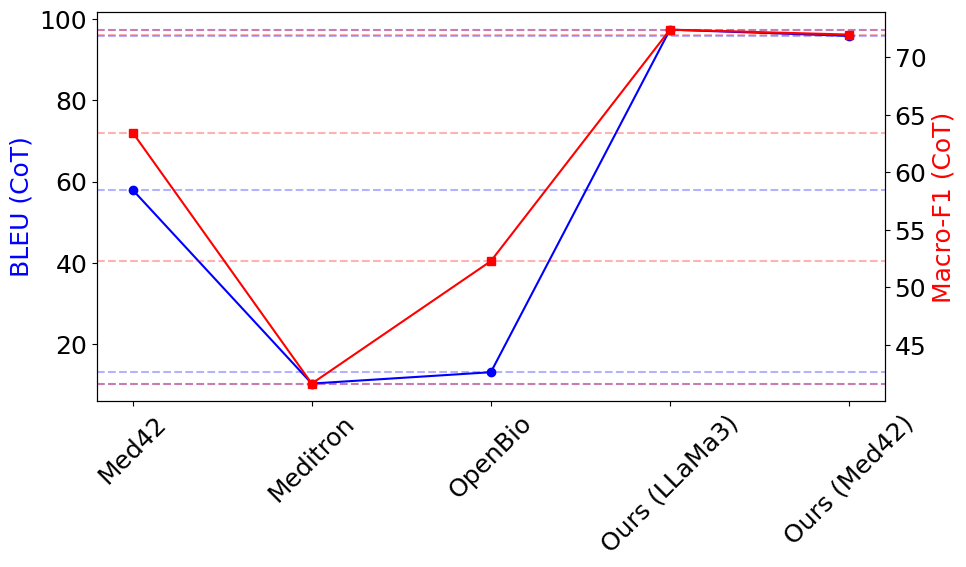

In [98]:
models = list(metrics.keys())
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
x = list(range(len(models)))

bleu_scores = [metrics[m]["cot"]["bleu"].score if hasattr(metrics[m]["cot"]["bleu"], 'score') else metrics[m]["cot"]["bleu"] for m in models]
f1_scores   = [metrics[m]["cot"]["macro_f1"] * 100 for m in models]

ax1.plot(x, bleu_scores, 'b-o', label='BLEU (CoT)')
ax2.plot(x, f1_scores, 'r-s', label='Macro-F1 (CoT)')

# Add horizontal marking lines
for score in bleu_scores:
    ax1.axhline(y=score, color='blue', linestyle='--', alpha=0.3)
for score in f1_scores:
    ax2.axhline(y=score, color='red', linestyle='--', alpha=0.3)

ax1.set_ylabel('BLEU (CoT)', color='blue')
ax2.set_ylabel('Macro-F1 (CoT)', color='red')
ax1.set_xticks(x)
ax1.set_xticklabels([name_map[m] for m in models], rotation=45)
# ax1.set_title("Reasoning Quality vs Classification Performance")

plt.tight_layout()
plt.savefig("plots/bleu_vs_f1_comparison.pdf", bbox_inches="tight")
plt.show()


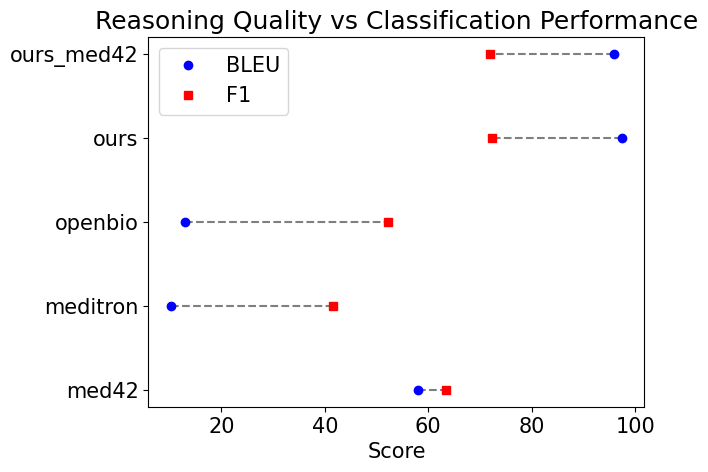

In [43]:
fig, ax = plt.subplots()

for i, m in enumerate(models):
    bleu = metrics[m]["cot"]["bleu"].score if hasattr(metrics[m]["cot"]["bleu"], 'score') else metrics[m]["cot"]["bleu"]
    f1   = metrics[m]["cot"]["macro_f1"]*100  # Scale F1 for better visibility
    ax.plot([bleu, f1], [i, i], 'k--', alpha=0.5)
    ax.plot(bleu, i, 'o', label='BLEU' if i == 0 else "", color='blue')
    ax.plot(f1, i, 's', label='F1' if i == 0 else "", color='red')

ax.set_yticks(range(len(models)))
ax.set_yticklabels(models)
ax.set_xlabel("Score")
ax.set_title("Reasoning Quality vs Classification Performance")
ax.legend()
# plt.tight_layout()
plt.show()


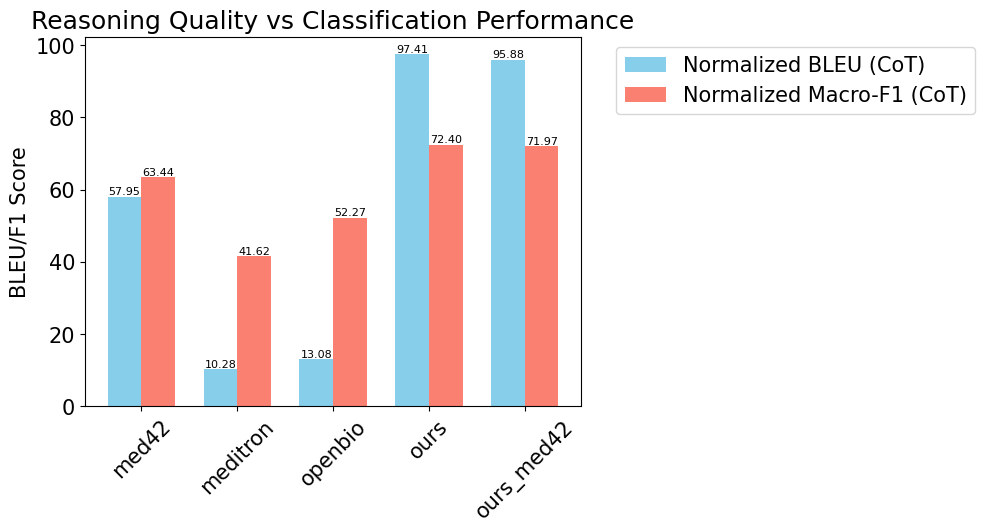

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

models = list(metrics.keys())
bleu_scores = []
f1_scores = []

# Extract BLEU and F1 scores
for m in models:
    bleu = metrics[m]["cot"]["bleu"].score if hasattr(metrics[m]["cot"]["bleu"], 'score') else metrics[m]["cot"]["bleu"]
    f1   = metrics[m]["cot"]["macro_f1"]
    bleu_scores.append(bleu)
    f1_scores.append(f1*100)

# Plot
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, bleu_scores, width, label='Normalized BLEU (CoT)', color='skyblue')
bars2 = ax.bar(x + width/2, f1_scores, width, label='Normalized Macro-F1 (CoT)', color='salmon')

ax.set_ylabel('BLEU/F1 Score')
ax.set_title("Reasoning Quality vs Classification Performance")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)

# Place the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add annotations
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom', fontsize=8)

# plt.tight_layout()
plt.show()

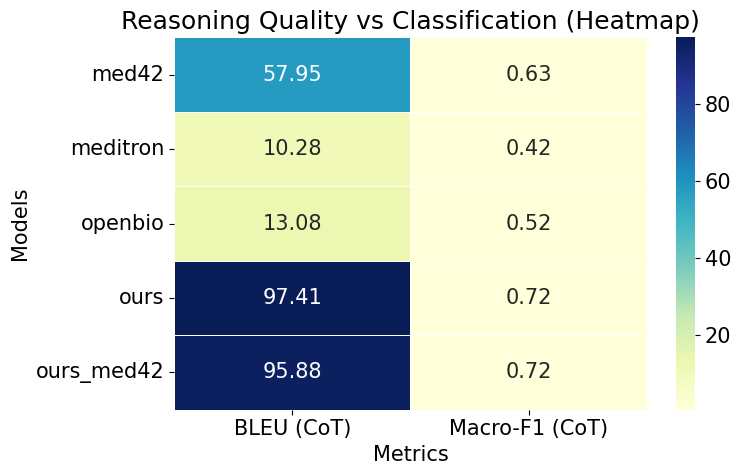

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data
data = {
    m: {
        "BLEU (CoT)": metrics[m]["cot"]["bleu"].score if hasattr(metrics[m]["cot"]["bleu"], 'score') else metrics[m]["cot"]["bleu"],
        "Macro-F1 (CoT)": metrics[m]["cot"]["macro_f1"]
    } for m in metrics
}

df = pd.DataFrame(data).T  # models as rows

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Reasoning Quality vs Classification (Heatmap)")
plt.ylabel("Models")
plt.xlabel("Metrics")
plt.tight_layout()
plt.show()


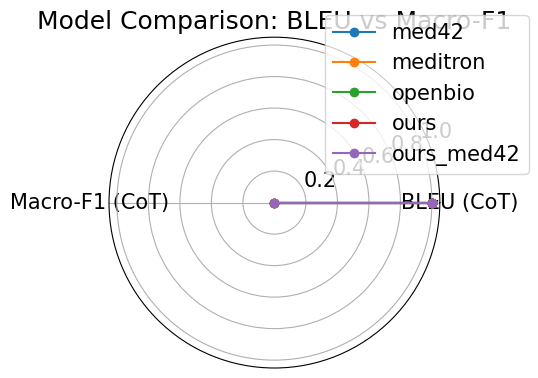

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize the values between 0 and 1 for radar plot clarity
def normalize(values):
    min_val, max_val = min(values), max(values)
    return [(v - min_val) / (max_val - min_val + 1e-6) for v in values]

# Prepare labels and data
labels = ["BLEU (CoT)", "Macro-F1 (CoT)"]
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for m in metrics:
    bleu = metrics[m]["cot"]["bleu"].score if hasattr(metrics[m]["cot"]["bleu"], 'score') else metrics[m]["cot"]["bleu"]
    f1   = metrics[m]["cot"]["macro_f1"]
    values = normalize([bleu, f1])
    values += values[:1]  # close the loop
    ax.plot(angles, values, label=m, marker='o')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Model Comparison: BLEU vs Macro-F1")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()
